In [ ]:
#### IMPORT LIBRARIES

#IMPORT TENSORFLOW
import tensorflow as tf
print("TF_VERSION: " + str(tf.__version__))

TF_VERSION: 2.3.0


In [ ]:
#OTHER LIBRARIES
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
#### PARAMETRI CUSTOMIZZABILI

BUFFER_SIZE = 287 #for perfect shuffling, put this value equal to the length of the dataset
BATCH_SIZE = 41 #256
PROGETTO='D:/Documents/Progetti/GAN_Fantasy'
PATH_IM_TO_GIF=str(PROGETTO)+'/epoch_images'
TRAIN_DIR='D:/Pictures/GanTrain/Folder_Train'

In [ ]:
#### LET'S IMPORT THE IMAGES FROM MY FOLDER
train_x=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) #Normalize between 0 and 1
train_images=train_x.flow_from_directory(directory=TRAIN_DIR,target_size=(256, 256))

print('TYPE TRAIN IMAGES: '+ str(type(train_images)))

#### They are imported as an Iterator, we need to convert them to numpy ndarray (This might not work on larger datasets)

train_images.reset()
train_images=np.concatenate([train_images.next()[0] for i in range(train_images.__len__())])

print('TYPE TRAIN IMAGES AFTER CONVERSION: '+ str(type(train_images)))
print('SHAPE TRAIN IMAGES AFTER CONVERSION: '+str(train_images.shape))

Found 285 images belonging to 1 classes.
TYPE TRAIN IMAGES: <class 'tensorflow.python.keras.preprocessing.image.DirectoryIterator'>
TYPE TRAIN IMAGES AFTER CONVERSION: <class 'numpy.ndarray'>
SHAPE TRAIN IMAGES AFTER CONVERSION: (285, 256, 256, 3)


In [ ]:
#### Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
print(train_dataset)

<BatchDataset shapes: (None, 256, 256, 3), types: tf.float32>


In [ ]:
#### Create Generator Model

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(64*64*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((64, 64, 256)))
    assert model.output_shape == (None, 64, 64, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 256, 256, 3)

    return model

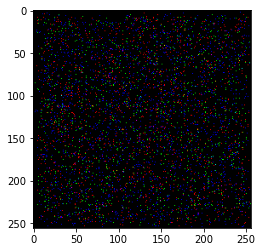

In [ ]:
#Generate an image

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
conv_img=np.array(generated_image[0, :, :, :]*255, np.uint8)

plt.imshow(conv_img #, cmap='rgb'
)

In [ ]:
#### Create the discriminator

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[256, 256, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
# Use the generator to recognize the true and false images (negative values for false images, positive values for true ones)
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00095094]], shape=(1, 1), dtype=float32)


In [ ]:
#### Define Loss and Optimizators for both models

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
# Discriminator Loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
# Generator Loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# We need two of them because we are going to train them on different models
generator_optimizer = tf.keras.optimizers.Adam(1e-4) #default: learning_rate=0.001, originale del codice: 1e-4
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
#### SAVE CHECKPOINTS

checkpoint_dir = str(PROGETTO)+'/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
#### Define TRAINING CYCLE

EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
#### Define TRAINING STEP

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
#### Define TRAINING PROCESS and saving

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
#### Generate and Save Images

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      #plt.imshow(predictions[i, :, :, :] *255  #, cmap='gray'
      #)
      plt.imshow(np.array(predictions[i, :, :, :]*255, np.uint8)#, cmap='gray'
      )
      plt.axis('off')

  plt.savefig(str(PATH_IM_TO_GIF)+'/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

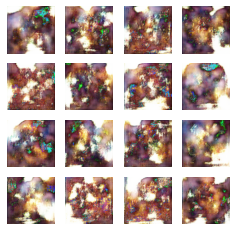

In [ ]:
#### LET'S START THE TRAINING

train(train_dataset, EPOCHS)

In [ ]:
#Ripristina l'ultimo checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
#CREA UNA GIF
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open(str(PATH_IM_TO_GIF)+'/image_at_epoch_{:04d}.png'.format(epoch_no))

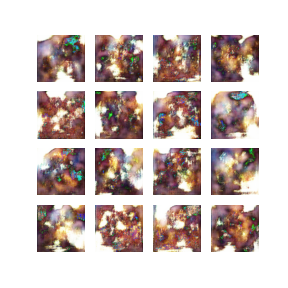

In [ ]:
display_image(EPOCHS)

In [ ]:
#animate all the pictures
anim_file = str(PATH_IM_TO_GIF)+'/dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob(str(PATH_IM_TO_GIF)+'/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed

embed.embed_file(anim_file)

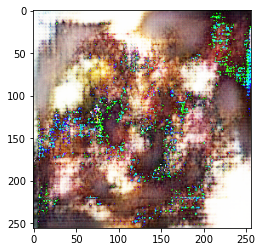

In [ ]:
#### LET'S GENERATE NEW IMAGES

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(np.array(generated_image[0, :, :, :]*255, np.uint8)#, cmap='gray'
)